## Initial Setup

In [539]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Import time series data: Airline passenger traffic

In [540]:
data = pd.read_csv('Source Data/airline-passenger-traffic.csv', header=None)
data.columns = ['Month', 'Passengers']
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data = data.set_index('Month')
data.head(12)

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
1949-06-01,135.0
1949-07-01,148.0
1949-08-01,148.0
1949-09-01,136.0


## Time series analysis

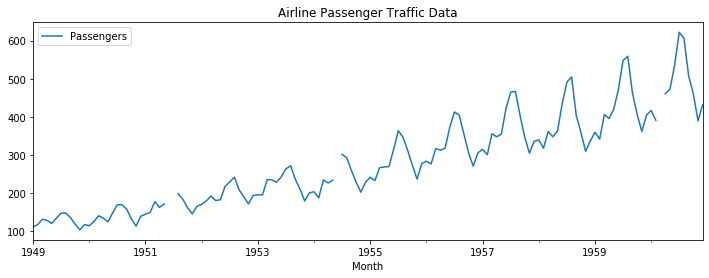

In [541]:
#Plot time series data
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Airline Passenger Traffic Data')
plt.show(block=False)

## Missing Value Treatment

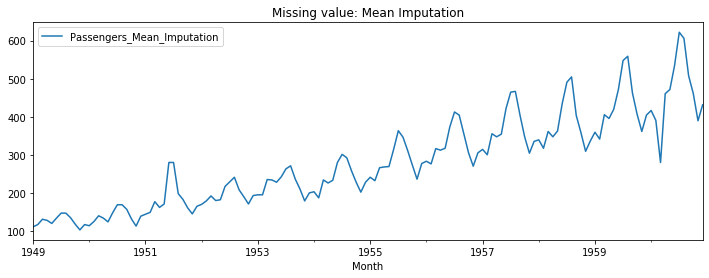

In [542]:
#Mean Imputation
data = data.assign(Passengers_Mean_Imputation = data.Passengers.fillna(data.Passengers.mean()))
data[['Passengers_Mean_Imputation']].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('Missing value: Mean Imputation')
plt.show(block=False)

### Linear Interpolation

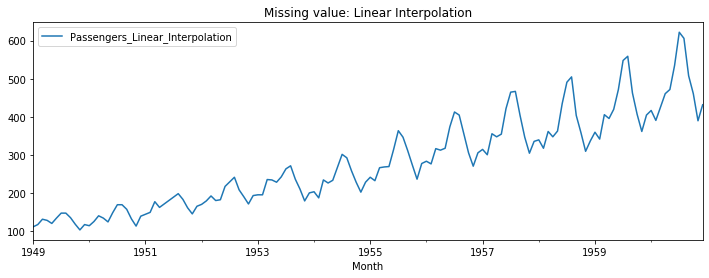

In [543]:
data = data.assign(Passengers_Linear_Interpolation = data.Passengers.interpolate(method='linear'))
data[['Passengers_Linear_Interpolation']].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('Missing value: Linear Interpolation')
plt.show(block=False)

In [544]:
data['Passengers'] = data['Passengers_Linear_Interpolation']

## Outlier Detection

### Box plot and interquartile range

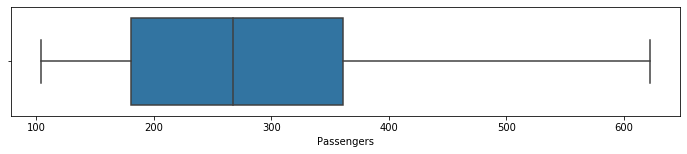

In [545]:
import seaborn as sns
fig = plt.subplots(figsize=(12,2))
ax = sns.boxplot(x = data['Passengers'], whis=1.5)

### Plot Histogram

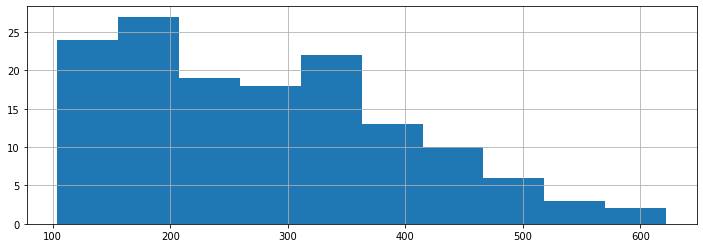

In [546]:
fig = data.Passengers.hist(figsize=(12,4))

## Time Series Decomposition

### Additive seasonal decomposition

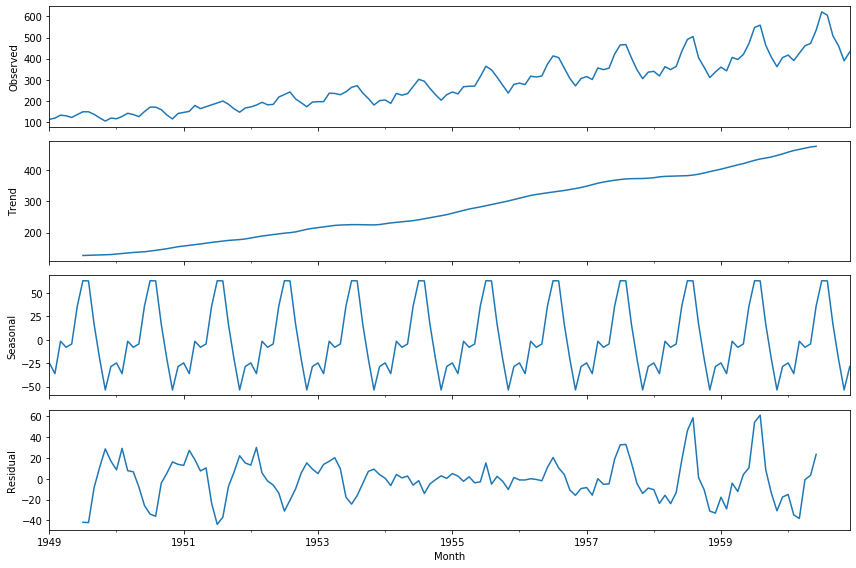

In [547]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12,8
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='additive')
fig = decomposition.plot()
plt.show()

### Multiplicative seasonal decomposition

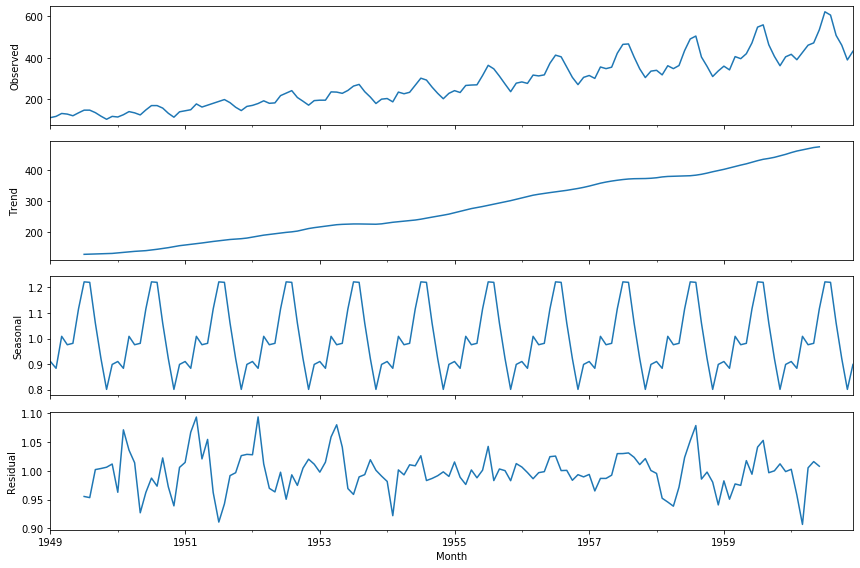

In [548]:
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='multiplicative')
fig = decomposition.plot()
plt.show()

## Build and evaulate time series forecast

### Splitting time series into Training and Test Sets

In [549]:
train_len = 120
train = data[0:train_len]
test = data[train_len:]

### Naive Method

In [550]:
y_hat_naive = test.copy()  #Initializing y_hat_naive with the test data as we need to forecast for the same date range.
y_hat_naive['naive_forecast'] = train['Passengers'][train_len-1]

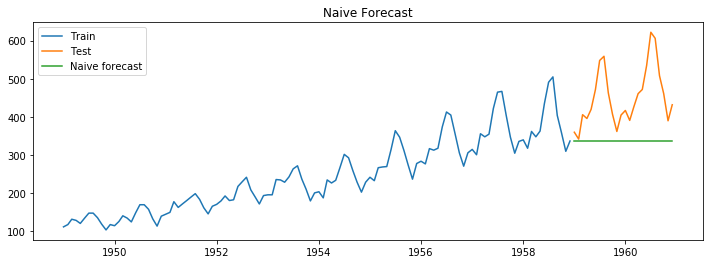

In [551]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Forecast')
plt.show()

## Calculate RMSE and MAPE to evaulate forecast - naive method

In [552]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_naive['naive_forecast'])/test['Passengers'])*100,2)

results = pd.DataFrame({'Method': ['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'MAPE', 'RMSE']]
results

#MAPE - 23.63% meaning that 76.37% is the accuracy of our naive model.

,Method,MAPE,RMSE
0,Naive method,23.63,137.51


### Simple Average Method

In [553]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Passengers'].mean()

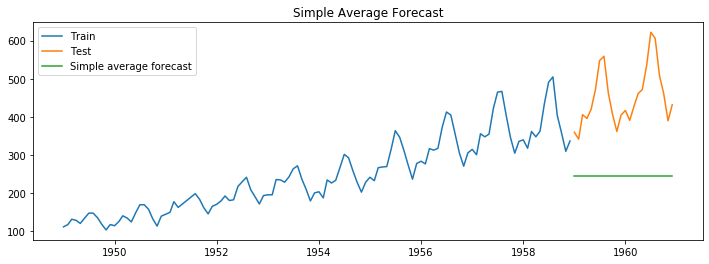

In [554]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.title('Simple Average Forecast')
plt.show()

## Calculate RMSE and MAPE to evaulate forecast - simple average method

In [555]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_avg['avg_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method': ['Simple average method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results,tempResults])
results

,Method,MAPE,RMSE
0,Naive method,23.63,137.51
0,Simple average method,44.28,219.69


## Simple moving average method

In [556]:
y_hat_sma = data.copy() #Initializing it with the entire data set as we want to see the past prediction
ma_window = 12
y_hat_sma['sma_forecast'] = data['Passengers'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1] #Since we won't have the data for the test points
# hence updating it with last data point

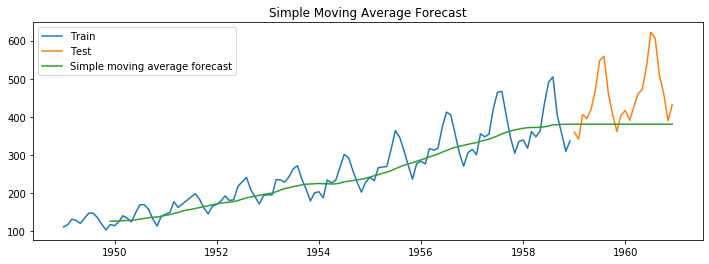

In [557]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Forecast')
plt.show()

## Calculate RMSE and MAPE to evaulate forecast - simple moving average method

In [558]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sma['sma_forecast'][train_len:])).round(2) # Using last 24 months data
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_sma['sma_forecast'][train_len:])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method': ['Simple moving average method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results, tempResults])
results

,Method,MAPE,RMSE
0,Naive method,23.63,137.51
0,Simple average method,44.28,219.69
0,Simple moving average method,15.54,103.33


## Simple Exponential Smoothing

In [559]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Passengers'])
model_fit = model.fit(smoothing_level=0.2,optimized=False) # optimized = False - as wehave explictly mentioned the parameters.
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(24)

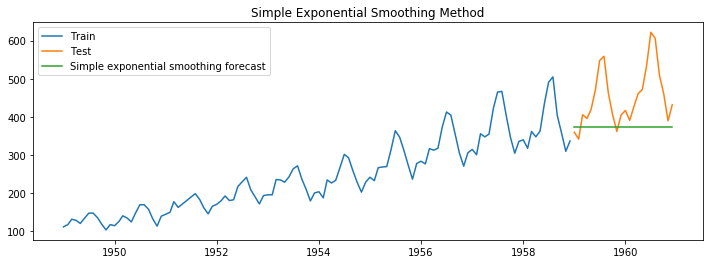

In [560]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show() # Level is been captured which is almost similar to the test data set

## Calculate RMSE and MAPE to evaulate forecast - Simple exponential smoothing method

In [561]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_ses['ses_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method': ['Simple exponential smoothing method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results, tempResults])
results

,Method,MAPE,RMSE
0,Naive method,23.63,137.51
0,Simple average method,44.28,219.69
0,Simple moving average method,15.54,103.33
0,Simple exponential smoothing method,16.49,107.65


## Holt's exponential smoothing method with Trend

In [562]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['Passengers']), seasonal_periods=12, trend='additive', seasonal=None)
#As the trend is linear, hence, using additive
# The parameter needs an array and np.asarry() converts the dataFrame into an array
model_fit = model.fit(smoothing_level=0.2, smoothing_slope=0.01, optimized=False)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.2, 'smoothing_slope': 0.01, 'smoothing_seasonal': None, 'damping_slope': nan, 'initial_level': 112.0, 'initial_slope': 6.0, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


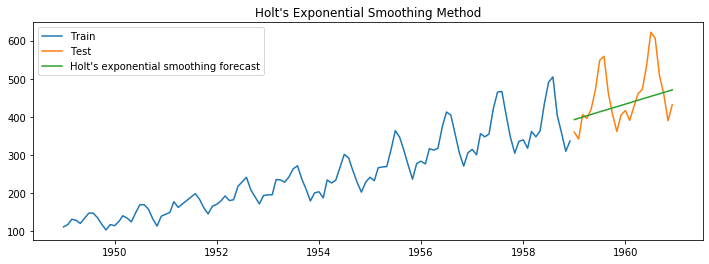

In [563]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

## Calculate RMSE and MAPE - Holt's exponential smoothing method

In [564]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_holt['holt_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method': ['Holt\'s exponential smoothing method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results,tempResults])
results = results[['Method', 'MAPE', 'RMSE']]
results

,Method,MAPE,RMSE
0,Naive method,23.63,137.51
0,Simple average method,44.28,219.69
0,Simple moving average method,15.54,103.33
0,Simple exponential smoothing method,16.49,107.65
0,Holt's exponential smoothing method,11.11,71.94


## Holt Winter's Additive Method with Trend and Seasonality

In [565]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Passengers']), seasonal_periods=12, trend='add',seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hwa_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.2631578931410015, 'smoothing_slope': 0.05162966025765116, 'smoothing_seasonal': 0.7368421036673173, 'damping_slope': nan, 'initial_level': 211.55099866332293, 'initial_slope': 1.7391915752033313, 'initial_seasons': array([-100.18118437,  -94.2046477 ,  -80.29175565,  -83.41758365,
        -91.45908078,  -77.4509434 ,  -64.48324357,  -64.57340564,
        -76.66644176,  -93.73584142, -108.67610965,  -94.50947707]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


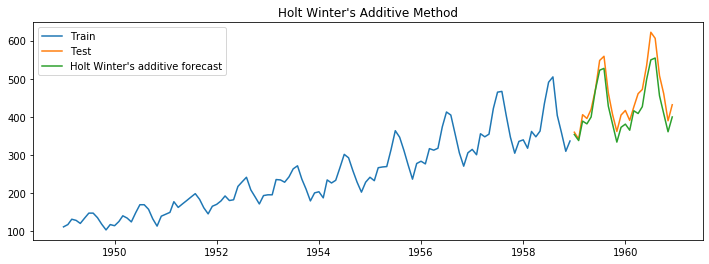

In [566]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_hwa['hwa_forecast'], label='Holt Winter\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winter\'s Additive Method')
plt.show()

## Calculate RMSE and MAPE to evaluate forecast - Holt Winter's additive method

In [567]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwa['hwa_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_hwa['hwa_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method': ['Holt Winter\'s additive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results,tempResults])
results = results[['Method', 'MAPE', 'RMSE']]
results

,Method,MAPE,RMSE
0,Naive method,23.63,137.51
0,Simple average method,44.28,219.69
0,Simple moving average method,15.54,103.33
0,Simple exponential smoothing method,16.49,107.65
0,Holt's exponential smoothing method,11.11,71.94
0,Holt Winter's additive method,6.53,35.10


## Holt Winter's Multiplicative Method with Trend and Seasonality

In [568]:
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['Passengers']), seasonal_periods=12, trend='add',seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hwm_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.38297792357726124, 'smoothing_slope': 0.035502695358352605, 'smoothing_seasonal': 0.6170220681283785, 'damping_slope': nan, 'initial_level': 212.3983506469908, 'initial_slope': 1.095376632423797, 'initial_seasons': array([0.51702061, 0.5454338 , 0.60215765, 0.56916567, 0.51982655,
       0.57235007, 0.62776238, 0.62555286, 0.57005795, 0.49511555,
       0.43967716, 0.51387414]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


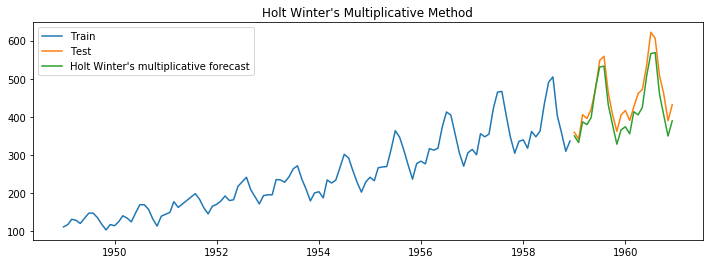

In [569]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_hwm['hwm_forecast'], label='Holt Winter\'s multiplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winter\'s Multiplicative Method')
plt.show()

## Calculate RMSE and MAPE to evaluate forecast - Holt Winter's multiplicative method

In [570]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwm['hwm_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_hwm['hwm_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method': ['Holt Winter\'s multiplicative method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results,tempResults])
results = results[['Method', 'MAPE', 'RMSE']]
results

,Method,MAPE,RMSE
0,Naive method,23.63,137.51
0,Simple average method,44.28,219.69
0,Simple moving average method,15.54,103.33
0,Simple exponential smoothing method,16.49,107.65
0,Holt's exponential smoothing method,11.11,71.94
0,Holt Winter's additive method,6.53,35.10
0,Holt Winter's multiplicative method,6.92,34.87


## Import time series data: Metrail dataset

In [571]:
data_metrail = pd.read_csv('Source Data/Metrail+dataset.csv', header=None)
data_metrail.columns = ['Month', 'Travellers']
data_metrail['Month'] = pd.to_datetime(data_metrail['Month'], format='%b-%y')
data_metrail = data_metrail.set_index('Month')
data_metrail.head(12)

,Travellers
Month,
1991-01-01,1724.0
1991-02-01,1638.0
1991-03-01,1987.0
1991-04-01,1825.0
1991-05-01,NaN
1991-06-01,1879.0
1991-07-01,1957.0
1991-08-01,2027.0
1991-09-01,1609.0


## Time series analysis

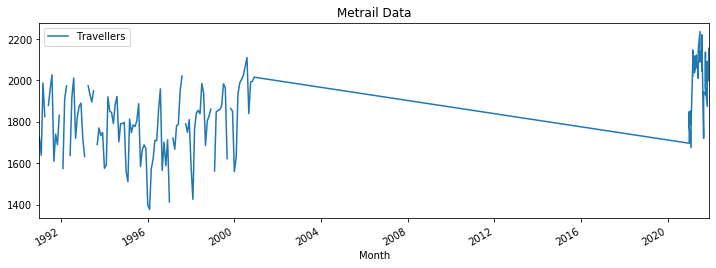

In [572]:
#Plot time series data
data_metrail.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Metrail Data')
plt.show(block=False)

## Missing Value Treatment

### Last observation carried forward

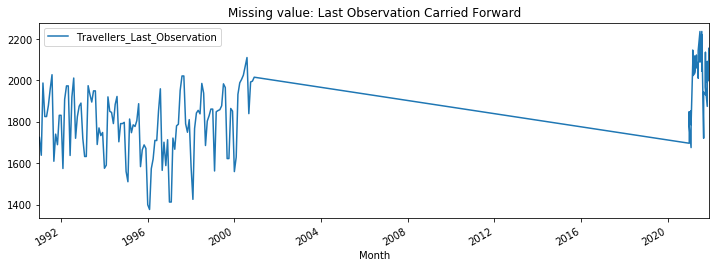

1838.685534591195


In [573]:
data_metrail = data_metrail.assign(Travellers_Last_Observation = data_metrail.Travellers.fillna(method='ffill'))
data_metrail[['Travellers_Last_Observation']].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('Missing value: Last Observation Carried Forward')
plt.show(block=False)

print(data_metrail.Travellers_Last_Observation.mean())

### Next value observation carried forward

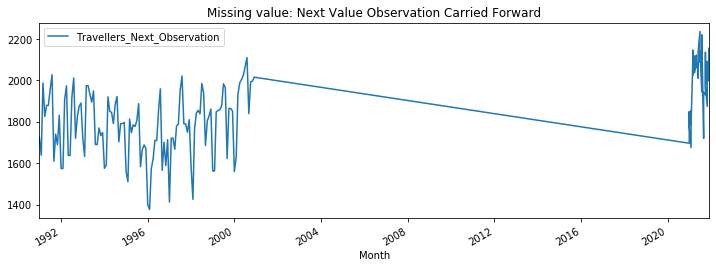

1834.446540880503


In [574]:
data_metrail = data_metrail.assign(Travellers_Next_Observation = data_metrail.Travellers.fillna(method='bfill'))
data_metrail[['Travellers_Next_Observation']].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('Missing value: Next Value Observation Carried Forward')
plt.show(block=False)

print(data_metrail.Travellers_Next_Observation.mean())

### Linear Interpolation

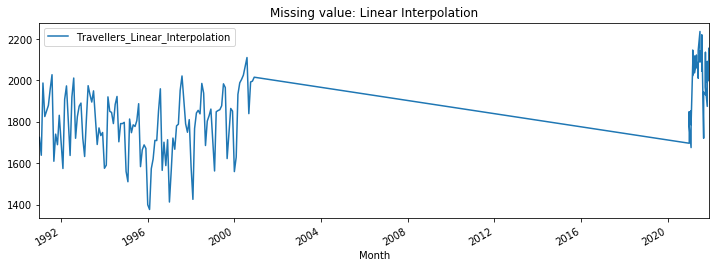

1836.566037735849


In [575]:
data_metrail = data_metrail.assign(Travellers_Linear_Interpolation = data_metrail.Travellers.interpolate(method='linear'))
data_metrail[['Travellers_Linear_Interpolation']].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('Missing value: Linear Interpolation')
plt.show(block=False)

print(data_metrail.Travellers_Linear_Interpolation.mean())

## Import time series data: Exchange Rate

In [576]:
data_exchange_rate = pd.read_csv('Source Data/exchange-rate-twi.csv')

## Build and evaulate time series forecast

### Splitting the data into train and test data

In [577]:
train_len = 212
train = data_exchange_rate[0:train_len]
test = data_exchange_rate[train_len:]

### Simple Average Method

In [578]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Exchange Rate TWI'].mean()
round(y_hat_avg,2)

,Month,Exchange Rate TWI,avg_forecast
212,213,52.5,88.33
213,214,53.1,88.33
214,215,53.8,88.33
215,216,55.2,88.33
216,217,58.9,88.33
...,...,...,...
299,300,49.6,88.33
300,301,48.5,88.33
301,302,48.4,88.33
302,303,51.0,88.33


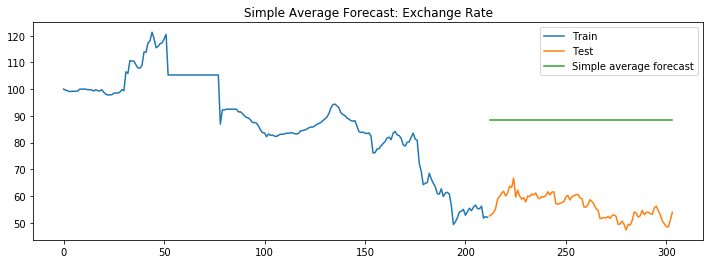

In [579]:
plt.figure(figsize=(12,4))
plt.plot(train['Exchange Rate TWI'], label='Train')
plt.plot(test['Exchange Rate TWI'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.title('Simple Average Forecast: Exchange Rate')
plt.show()

### Calculating RMSE and MAPE - simple average method

In [580]:
rmse = np.sqrt(mean_squared_error(test['Exchange Rate TWI'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Exchange Rate TWI']-y_hat_avg['avg_forecast'])/test['Exchange Rate TWI'])*100,2)

results = pd.DataFrame({'Method': ['Simple Forecast Method'], 'RMSE': [rmse], 'MAPE': [mape]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple Forecast Method,32.42,58.12


### Naive Method

In [581]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Exchange Rate TWI'][train_len-1]
y_hat_naive

,Month,Exchange Rate TWI,naive_forecast
212,213,52.5,52.0
213,214,53.1,52.0
214,215,53.8,52.0
215,216,55.2,52.0
216,217,58.9,52.0
...,...,...,...
299,300,49.6,52.0
300,301,48.5,52.0
301,302,48.4,52.0
302,303,51.0,52.0


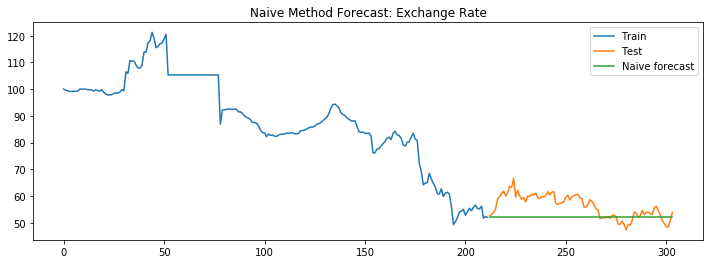

In [582]:
plt.figure(figsize=(12,4))
plt.plot(train['Exchange Rate TWI'], label='Train')
plt.plot(test['Exchange Rate TWI'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method Forecast: Exchange Rate')
plt.show()

### Calculating RMSE and MAPE - naive method

In [583]:
rmse = np.sqrt(mean_squared_error(test['Exchange Rate TWI'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Exchange Rate TWI']-y_hat_naive['naive_forecast'])/test['Exchange Rate TWI'])*100,2)

tempResults = pd.DataFrame({'Method': ['Naive Method'], 'RMSE': [rmse], 'MAPE': [mape]})
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Simple Forecast Method,32.42,58.12
0,Naive Method,5.98,8.41


## Simple Moving Average Method

In [584]:
y_hat_sma = data_exchange_rate.copy()
ma_window = 3
y_hat_sma['sma_forecast'] = data_exchange_rate['Exchange Rate TWI'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

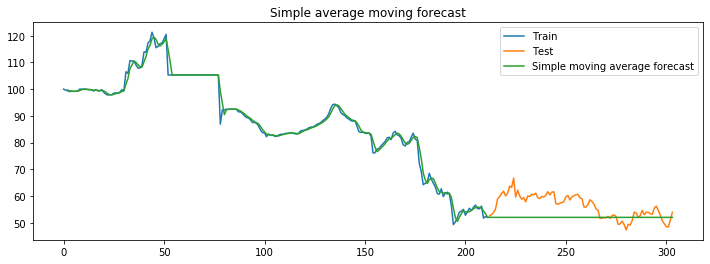

In [585]:
plt.figure(figsize=(12,4))
plt.plot(train['Exchange Rate TWI'], label='Train')
plt.plot(test['Exchange Rate TWI'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple average moving forecast')
plt.show()

## Calculate RMSE and MAPE - simple moving average method

In [586]:
rmse = np.sqrt(mean_squared_error(test['Exchange Rate TWI'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Exchange Rate TWI']-y_hat_sma['sma_forecast'][train_len:])/test['Exchange Rate TWI'])*100,2)

tempResults = pd.DataFrame({'Method': ['Simple Average Moving Method(3 mths)'], 'RMSE': [rmse], 'MAPE': [mape]})
results = pd.concat([results,tempResults])
results

,Method,RMSE,MAPE
0,Simple Forecast Method,32.42,58.12
0,Naive Method,5.98,8.41
0,Simple Average Moving Method(3 mths),5.98,8.41


## Import time series data: Daily Temperature

In [587]:
data_daily_temp = pd.read_csv('Source Data/Daily+temperature+data.csv')

### Splitting the data into train and test data

In [597]:
train_len = 511
train = data_daily_temp[0:train_len]
test = data_daily_temp[train_len:]
test

,Date,Temperature(Min)
511,5/27/2018,8.2
512,5/28/2018,6.1
513,5/29/2018,4.5
514,5/30/2018,6.1
515,5/31/2018,9.8
...,...,...
725,12/27/2018,14.0
726,12/28/2018,13.6
727,12/29/2018,13.5
728,12/30/2018,15.7


## Simple Exponential Smoothing

In [589]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Temperature(Min)'])
model_fit = model.fit(smoothing_level=0.2,optimized=False)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(220)

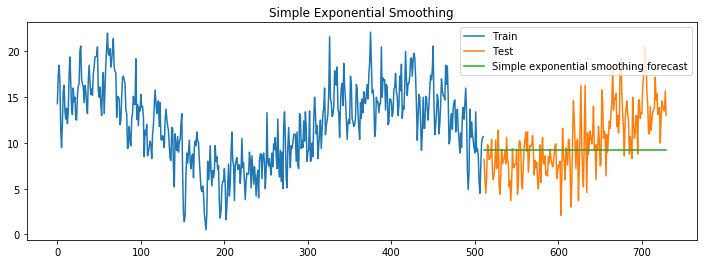

In [590]:
plt.figure(figsize=(12,4))
plt.plot(train['Temperature(Min)'], label='Train')
plt.plot(test['Temperature(Min)'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing')
plt.show()

## Calculate RMSE and MAPE to evaulate forecast - Simple exponential smoothing method

In [591]:
rmse = np.sqrt(mean_squared_error(test['Temperature(Min)'],y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Temperature(Min)']-y_hat_ses['ses_forecast'])/test['Temperature(Min)'])*100,2)

results = pd.DataFrame({'Method': ['Simple exponential smoothing method'], 'RMSE': [rmse], 'MAPE': [mape]})
results

,Method,RMSE,MAPE
0,Simple exponential smoothing method,3.56,30.24


## Holt's Exponential Smoothing Technique

In [598]:
model = ExponentialSmoothing(np.asarray(train['Temperature(Min)']), seasonal_periods=12, trend='additive', seasonal=None)
#As the trend is linear, hence, using additive
# The parameter needs an array and np.asarry() converts the dataFrame into an array
model_fit = model.fit(smoothing_level=0.5, smoothing_slope=0.01, optimized=False)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(219)
y_hat_holt

{'smoothing_level': 0.5, 'smoothing_slope': 0.01, 'smoothing_seasonal': None, 'damping_slope': nan, 'initial_level': 14.3, 'initial_slope': 3.099999999999998, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


,Date,Temperature(Min),holt_forecast
511,5/27/2018,8.2,10.013934
512,5/28/2018,6.1,10.003336
513,5/29/2018,4.5,9.992737
514,5/30/2018,6.1,9.982139
515,5/31/2018,9.8,9.971541
...,...,...,...
725,12/27/2018,14.0,7.745885
726,12/28/2018,13.6,7.735286
727,12/29/2018,13.5,7.724688
728,12/30/2018,15.7,7.714090


## Calculate RMSE and MAPE - Holt's exponential smoothing method

In [593]:
rmse = np.sqrt(mean_squared_error(test['Temperature(Min)'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Temperature(Min)']-y_hat_holt['holt_forecast'])/test['Temperature(Min)'])*100,2)

tempResults = pd.DataFrame({'Method': ['Holt\'s exponential smoothing method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results,tempResults])
results = results[['Method', 'MAPE', 'RMSE']]
results

,Method,MAPE,RMSE
0,Simple exponential smoothing method,30.24,3.56
0,Holt's exponential smoothing method,34.17,4.11


## Holt Winter's Additive Method with Trend and Seasonality

In [599]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Temperature(Min)']), seasonal_periods=30, trend='add',seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hwa_forecast'] = model_fit.forecast(219)

{'smoothing_level': 0.6746181790382475, 'smoothing_slope': 2.9104944726839204e-25, 'smoothing_seasonal': 1.3135682334928428e-24, 'damping_slope': nan, 'initial_level': 12.385428247523706, 'initial_slope': 5.472519563107773e-23, 'initial_seasons': array([3.06576585, 2.57167561, 2.59347279, 3.1032156 , 2.57753832,
       2.39890865, 2.50841099, 3.15923703, 3.31009357, 2.99042322,
       3.07098738, 2.81638854, 1.82038689, 2.77133564, 2.96935768,
       2.99683318, 1.94766889, 2.75726549, 2.45511863, 1.77655286,
       1.9980976 , 2.83114692, 1.658501  , 0.96252584, 1.82557137,
       1.82975108, 2.09879099, 2.71482524, 3.23098637, 3.24699864]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


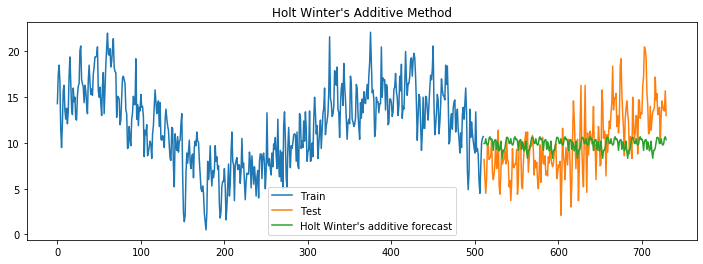

In [600]:
plt.figure(figsize=(12,4))
plt.plot(train['Temperature(Min)'], label='Train')
plt.plot(test['Temperature(Min)'], label='Test')
plt.plot(y_hat_hwa['hwa_forecast'], label='Holt Winter\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winter\'s Additive Method')
plt.show()

## Calculate RMSE and MAPE to evaluate forecast - Holt Winter's additive method

In [602]:
rmse = np.sqrt(mean_squared_error(test['Temperature(Min)'], y_hat_hwa['hwa_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Temperature(Min)']-y_hat_hwa['hwa_forecast'])/test['Temperature(Min)'])*100,2)

tempResults = pd.DataFrame({'Method': ['Holt Winter\'s additive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = pd.concat([results,tempResults])
results = results[['Method', 'MAPE', 'RMSE']]
results

,Method,MAPE,RMSE
0,Simple exponential smoothing method,30.24,3.56
0,Holt's exponential smoothing method,34.17,4.11
0,Holt Winter's additive method,32.83,3.50
